# 02: Advanced Usage and Solver Capabilities

This notebook demonstrates the advanced utilities included in Quasar Solver that help controlling and visualizing the annealing process, such as:

1.  **Solver Parameters**: Understanding how different parameters affect performance.
2.  **Automatic Parameter Estimation**: How quasar estimates values for the parameters based on problem structure.
3.  **Adaptive Cooling**: Using the advanced cooling schedule.
4.  **Visualizing the Process**: Using built-in plotting tools to understand the annealing process.

In [16]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from quasar_solver import QUBO, Solver
from quasar_solver.plot import plot_energy_convergence, plot_acceptance_probability, plot_temperature_schedule
from quasar_solver.schedules import geometric_cooling, adaptive_cooling

print("Imports successful.")

Imports successful.


## 1. Generating a Structured Problem: Max-Cut

For demonstration purposes, we will use a reasonable complex **Max-Cut** problem instance on random graph (Erdős-Rényi) with varied connectivity.

The Max-Cut problem asks to partition the nodes of a graph into two sets such that the number of edges between the sets is maximized.

We use `networkx` to create a random graph with 500 nodes. This provides a challenging landscape for the solver.

In [17]:
# Generate a random graph with 500 nodes
N = 500
G = nx.fast_gnp_random_graph(N, p=0.2, seed=42)

# Add random weights to create a "rough" energy landscape
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = np.random.uniform(0.5, 5.0)

# Convert to QUBO formulation for Max-Cut
# Max-Cut object: Maximize sum_{(i,j) in E} (zi + zj - 2 zi zj)
# Equivalent to minimizing QUBO energy: Q_ij = 2 for edges, Q_ii = -degree
adjacency = nx.to_numpy_array(G)
Q_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(i + 1, N):
        if adjacency[i, j]:
            Q_matrix[i, j] = 2.0
            Q_matrix[j, i] = 2.0
    # Diagonal terms (negative degree)
    Q_matrix[i, i] = -np.sum(adjacency[i, :])

problem = QUBO(Q_matrix)
print(f"Generated Max-Cut QUBO for {N}-node random 3-regular graph.")

Generated Max-Cut QUBO for 500-node random 3-regular graph.


## 2. Automatic Parameter Estimation and Plotting tools

The Quasar Solver includes utilities to automatically estimate optimal annealing parameters based on the problem's energy landscape.

1. **Initial Temperature ($T_0$)**:  Estimated such that the initial acceptance probability is high (~80%).
   $$ T_{max} \approx \frac{-\max(\Delta E)}{\ln(p_{start})} $$
   where $\max(\Delta E)$ is an estimate of the maximum energy barrier.

2. **Final Temperature ($T_f$)**: Estimated such that the final acceptance probability is extremely low (~0.01%).
   $$ T_{min} \approx \frac{-\min(\Delta E)}{\ln(p_{end})} $$
     where $\min(\Delta E)$ is the smallest non-zero energy change possible.


In [18]:
# Initialize solver without specifying parameters to use auto-estimation
auto_solver = Solver(qubo=problem)

print(f"Estimated Initial Temp: {auto_solver.initial_temp:.4f}")
print(f"Estimated Final Temp:   {auto_solver.final_temp:.6f}")
print(f"Estimated Iterations:   {auto_solver.iterations_per_temp}")
print(f"Cooling Rate (alpha):   {auto_solver.cooling_rate}")

Estimated Initial Temp: 2794.8815
Estimated Final Temp:   0.217147
Estimated Iterations:   5000
Cooling Rate (alpha):   0.99


The automatic parameter estimation ensures that the solver can find a good solution for a wide range of problems while requiring minimal user input and balancing between performance and ease of use.

To visualize the annealing process based on the estimated parameters, we can use the built-in plotting functionalities of the solver. To collect the necessary data including intermediate results, as well as the development of energy, acceptances and temperature, we run the solver with `track_history=True`.

In [19]:
solver = Solver(
    qubo=problem,
    track_history=True
)

result = solver.solve()

print(f'\nSolver finished.')
print(f'Lowest energy found: {result.energy}')

Annealing complete. Final energy: -51554.06498957315

Solver finished.
Lowest energy found: -51554.06498957315


The Quasar solver offers three built-in plotting tools that help understanding the performance and efficiency of the annealing process:

1. **Energy Convergence Plot**: Visualizes the trajectory of the best and current energy during the annealing process.
2. **Acceptance Rate Plot**:  Visualizes the acceptance rate of the MCMC steps over the course of the temperature decline.
3. **Temperature Evolution Plot**:  Visualizes the cooling schedule over the course of the annealing process.

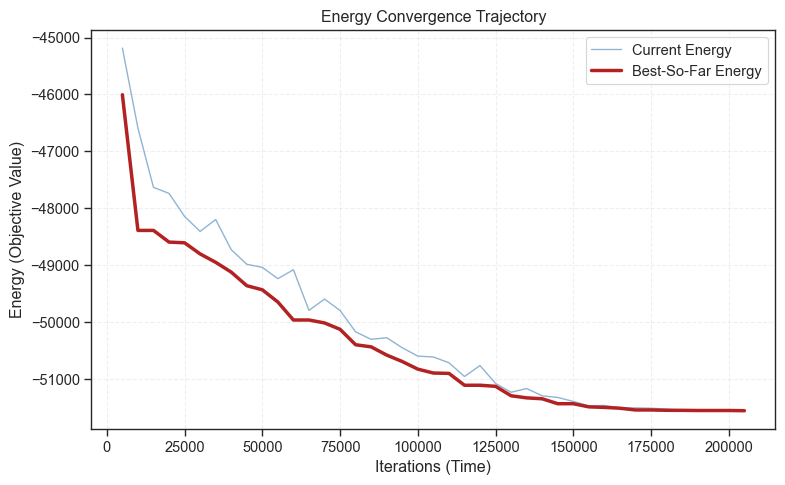

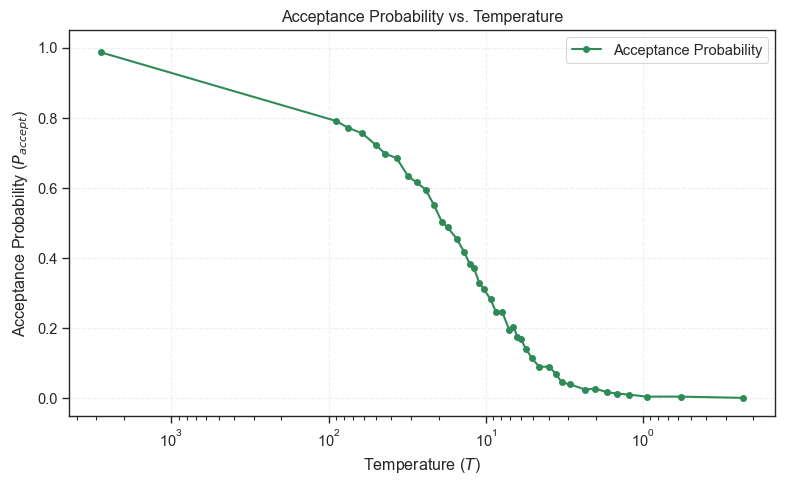

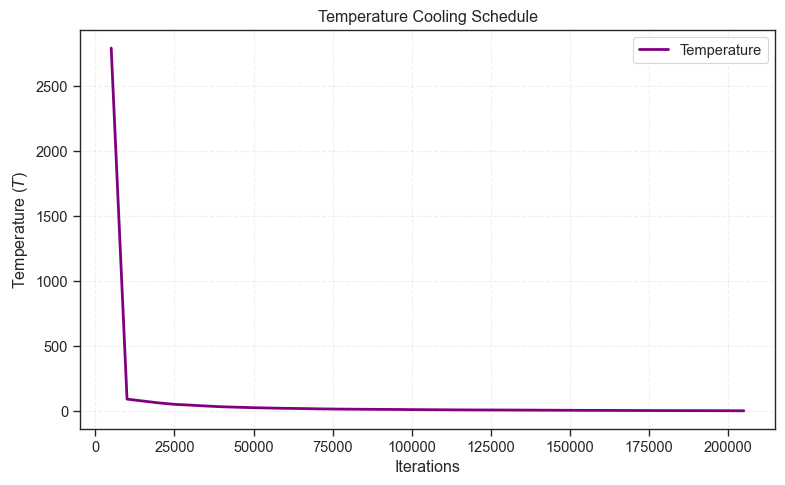

In [20]:
plot_energy_convergence(result.history) 
plot_acceptance_probability(result.history) 
plot_temperature_schedule(result.history) 


These plots can be used to further analyze the impact of the parameter values. For demonstration pruproses, we will run the solver again with significantly increased initial temperature and reduced iterations per temperature to see the different annealing behavior.

Annealing complete. Final energy: -51515.51011322996


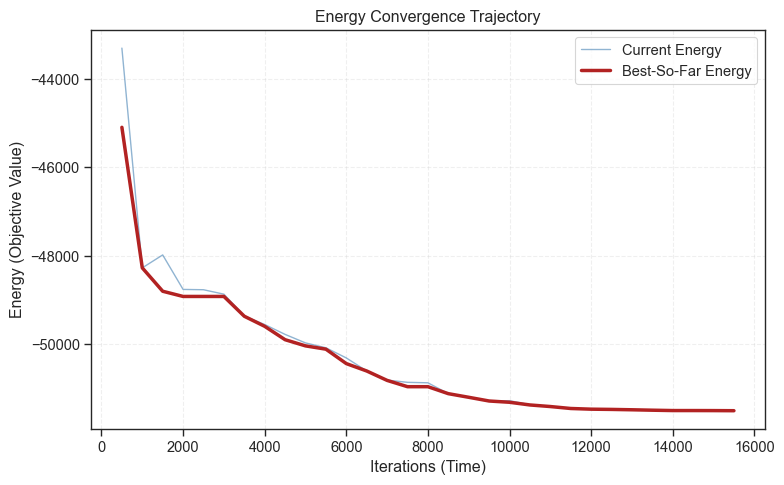

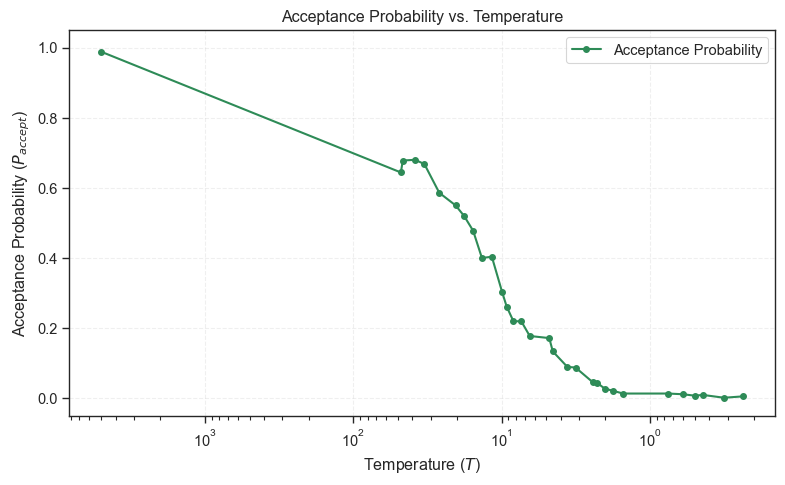

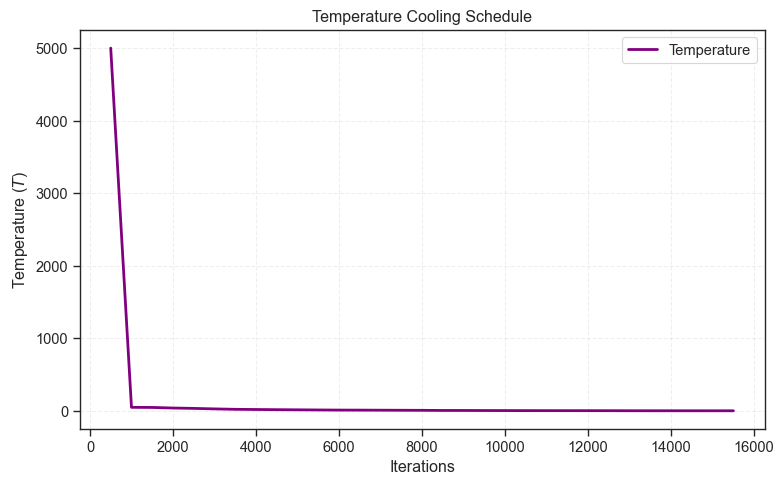

In [21]:
solver = Solver(
    qubo=problem,
    initial_temp=5000,
    iterations_per_temp=500,
    track_history=True
)

result = solver.solve()

plot_energy_convergence(result.history) 
plot_acceptance_probability(result.history) 
plot_temperature_schedule(result.history) 


## 3. Cooling Schedules

The Quasar Solver offers two cooling schedules: **Geometric Cooling** and **Adaptive (Huang) Cooling**.
Geometric cooling uses a fixed cooling rate, while adaptive cooling adjusts the temperature based on the specific heat (standard deviation of energy), potentially slowing down cooling in critical regions where phase transitions occur.

Geometric cooling is the default approach for simpler or sparse optimization landscapes. It reduces the temperature at a fixed, constant rate given by

$$T_{k+1} = \alpha \cdot T_k$$

At each step, the current temperature $T_k$ is multiplied by a cooling factor $\alpha$, typically between $0.8$ and $0.99$. This schedule has minimal computational overhead and is highly effective for landscapes where the global minimum is not obscured by deep local minima.

For complex, dense problems, the solver triggers **Huang’s Adaptive Cooling**. This schedule is "state-aware," using thermodynamic feedback (the standard deviation of energy) to adjust the cooling speed:

$$T_{k+1} = T_k \cdot \exp\left( -\frac{\lambda \cdot T_k}{\sigma_E} \right)$$

The solver measures the standard deviation of energy $\sigma_E$ during the MCMC chain at each temperature. If $\sigma_E$ is high, it indicates a "rough" landscape, and the temperature drop becomes smaller to allow more exploration. It prevents **quenching** (cooling too fast), which often traps solvers in local minima. This allows the Quasar Solver to navigate "frustrated" systems where complex interactions exist between many variables. Generally, it is much more "problem-specific" and can therefore also significantly reduce runtime in less-complex energy landscapes.

In [22]:
# 1. Geometric Cooling
print("Running Geometric Cooling...")
solver_geo = Solver(
    qubo=problem,
    schedule=geometric_cooling,
    track_history=True
)
result_geo = solver_geo.solve()

# 2. Adaptive Cooling
print("\nRunning Adaptive Cooling...")
solver_adapt = Solver(
    qubo=problem,
    schedule=adaptive_cooling,
    track_history=True
)
result_adapt = solver_adapt.solve()

print(f"\nGeometric Energy: {result_geo.energy:.4f}")
print(f"Adaptive Energy:  {result_adapt.energy:.4f}")

Running Geometric Cooling...
Annealing complete. Final energy: -51554.06498957639

Running Adaptive Cooling...
Annealing complete. Final energy: -51554.064989573235

Geometric Energy: -51554.0650
Adaptive Energy:  -51554.0650


Let's visually compare the temperature schedules and convergence.

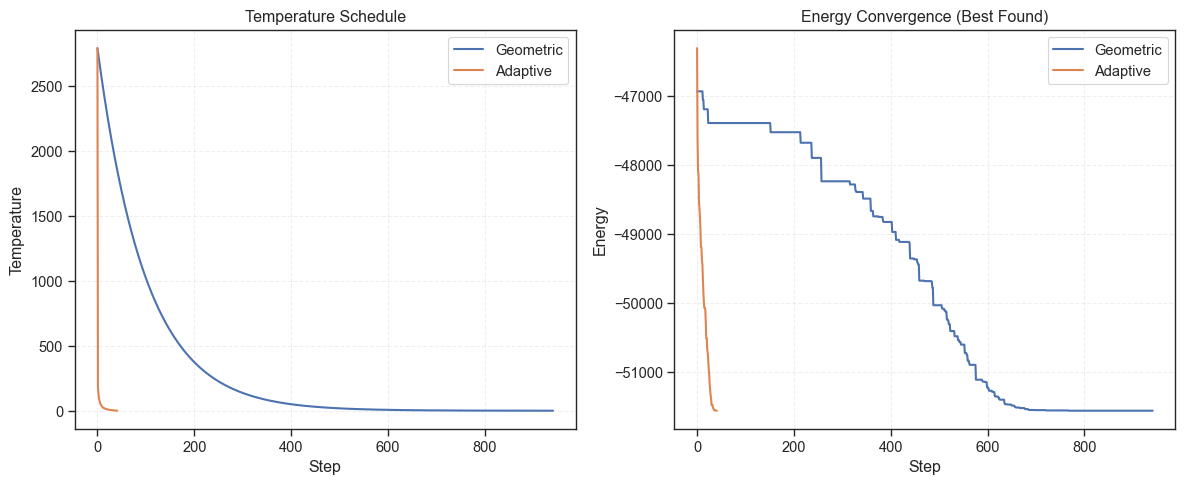

In [23]:
plt.figure(figsize=(12, 5))

# Compare Temperature Schedules
plt.subplot(1, 2, 1)
plt.plot(result_geo.history['temperatures'], label='Geometric')
plt.plot(result_adapt.history['temperatures'], label='Adaptive')
plt.title('Temperature Schedule')
plt.xlabel('Step')
plt.ylabel('Temperature')
plt.legend()

# Compare Energy Convergence
plt.subplot(1, 2, 2)
plt.plot(result_geo.history['best_energies'], label='Geometric')
plt.plot(result_adapt.history['best_energies'], label='Adaptive')
plt.title('Energy Convergence (Best Found)')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Runtime acceleration: Multiprocessing & JIT

Quasar Solver uses **Numba JIT** for the MCMC kernels and **Multiprocessing** to run parallel chains.
While the coordination overhead for multiprocessing can increase runtime for smaller problems, it can provide significant speedups for larger problems.

In [26]:

# Sequential (force single process)
print(f"Benchmarking Sequential execution ...")
start_time = time.time()
solver_seq = Solver(qubo=problem, multiprocessing=False)
res_seq = solver_seq.solve()
time_seq = time.time() - start_time

# Parallel
print(f"Benchmarking Parallel execution with ...")
start_time = time.time()
solver_par = Solver(qubo=problem, multiprocessing=True)
res_par = solver_par.solve()

time_par = time.time() - start_time

print(f"Sequential : {time_seq:.4f}s")
print(f"Parallel :   {time_par:.4f}s")
print(f"Speedup: {time_seq/time_par:.2f}x")

Benchmarking Sequential execution ...
Annealing complete. Final energy: -51554.06498957313
Benchmarking Parallel execution with ...
Annealing complete. Final energy: -51554.064989573286
Sequential : 5.0017s
Parallel :   3.2061s
Speedup: 1.56x
